# GitOps Flow with MLRun

In [3]:
# !pip install s3fs

## Setup Project

In [15]:
import os
import json
import mlrun
import pandas as pd

from config import AppConfig

config = AppConfig()

project = mlrun.get_or_create_project(
    name=config.project_name,
    parameters={
        "source" : config.archive_source,
        "secrets_file" : config.secrets_file,
        "artifact_path" : config.artifact_path,
        "force_build" : False
    }
)

> 2025-02-03 23:31:20,197 [warning] Overwriting artifact old db_key 'model' with new key 'model' - artifact can be fetched using the new key only
Project Source: v3io:///bigdata/cicd-flow.zip
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...
> 2025-02-03 23:31:22,222 [info] Project loaded successfully: {"project_name":"cicd-flow"}


## Log Training Set

In [3]:
dataset = project.log_dataset(key="heart", df=pd.read_csv(config.source_url))
dataset.uri

'store://datasets/cicd-flow/heart#0@e26fdef1f591c1c6b03296df074095b98451e89c'

## Run Training Pipeline

In [4]:
train_config = config.get_workflow_config(
    workflow_name="train",
    source_url=dataset.uri
)
train_config

{'source_url': 'store://datasets/cicd-flow/heart#0@e26fdef1f591c1c6b03296df074095b98451e89c',
 'label_column': 'target',
 'allow_validation_failure': True,
 'ohe_columns': ['sex', 'cp', 'slope', 'thal', 'restecg'],
 'test_size': 0.2}

In [5]:
project.notifiers.add_notification(notification_type="slack", params={"webhook": os.getenv("SLACK_WEBHOOK_URL")})

> 2025-02-03 23:16:03,987 [warning] WARNING!, You seem to have uncommitted git changes, use .push()
> 2025-02-03 23:16:05,608 [info] Pipeline submitted successfully: {"id":"1e587e9e-f0e3-4ddd-9566-b7d7ff655841","pipeline_name":"cicd-flow-train 2025-02-03 23-16-04"}
> 2025-02-03 23:16:05,609 [info] Pipeline run id=1e587e9e-f0e3-4ddd-9566-b7d7ff655841, check UI for progress


> 2025-02-03 23:16:05,793 [info] Started run workflow cicd-flow-train with run id = '1e587e9e-f0e3-4ddd-9566-b7d7ff655841' by kfp engine
> 2025-02-03 23:16:05,794 [info] Waiting for pipeline run completion: {"project":"cicd-flow","run_id":"1e587e9e-f0e3-4ddd-9566-b7d7ff655841"}


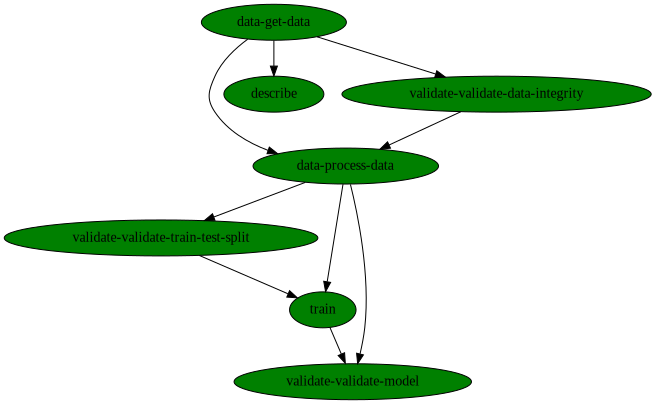

uid,start,state,kind,name,parameters,results
...49666784,Feb 03 23:19:08,completed,run,validate-validate-model,model_path=store://models/cicd-flow/model:latest@1e587e9e-f0e3-4ddd-9566-b7d7ff655841label_column=targetallow_validation_failure=True,passed_suite=False
...f19ac1da,Feb 03 23:18:14,completed,run,train,label_column=target,best_iteration=2accuracy=0.8771929824561403f1_score=0.8771929824561403precision_score=0.8333333333333334recall_score=0.9259259259259259
...d23e1d62,Feb 03 23:17:42,completed,run,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...30ec7658,Feb 03 23:17:12,completed,run,data-process-data,"label_column=targettest_size=0.2ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...f561ab58,Feb 03 23:16:44,completed,run,describe,label_column=target,
...0d7e5537,Feb 03 23:16:44,completed,run,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...21519d65,Feb 03 23:16:16,completed,run,data-get-data,,


In [6]:
run_id = project.run(
    name="train",
    arguments=train_config,
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [16]:
deploy_config = config.get_workflow_config(workflow_name="deploy")

> 2025-02-03 23:31:26,864 [warning] WARNING!, You seem to have uncommitted git changes, use .push()
> 2025-02-03 23:31:27,489 [info] Pipeline submitted successfully: {"id":"19b60085-fbdb-4c71-9cdf-49e8d8280ca7","pipeline_name":"cicd-flow-deploy 2025-02-03 23-31-27"}
> 2025-02-03 23:31:27,490 [info] Pipeline run id=19b60085-fbdb-4c71-9cdf-49e8d8280ca7, check UI for progress


> 2025-02-03 23:31:27,564 [info] Started run workflow cicd-flow-deploy with run id = '19b60085-fbdb-4c71-9cdf-49e8d8280ca7' by kfp engine
> 2025-02-03 23:31:27,565 [info] Waiting for pipeline run completion: {"project":"cicd-flow","run_id":"19b60085-fbdb-4c71-9cdf-49e8d8280ca7"}


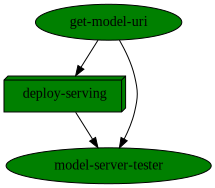

uid,start,state,kind,name,parameters,results
...b5bc1533,Feb 03 23:33:34,completed,run,model-server-tester,addr=http://cicd-flow-serving.default-tenant.app.cst-360.iguazio-cd0.com/label_column=targetmodel=model,total_tests=20errors=0match=10avg_latency=36767min_latency=34400max_latency=40425
...cac9042e,Feb 03 23:31:34,completed,run,get-model-uri,model_name=modelmodel_tag=challenger,model_uri=store://models/cicd-flow/model#0:challengertest_set_uri=s3://iguazio-demo/projects/cicd-flow/artifacts/d743ad84-8616-4fe9-a082-c6dc1567a717/train/1/test_set.parquet


In [17]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config,
    dirty=True,
    watch=True
)

### Invoke Model

In [18]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config.deploy_model_name
label_column = config.label_column

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


In [19]:
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

> 2025-02-03 23:34:03,921 [info] Invoking function: {"method":"POST","path":"http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer"}


{'id': '4d713478-d683-4176-b68c-c800089b6120',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0],
 'timestamp': '2025-02-03 23:34:03.936233+00:00',
 'model_version': 'challenger'}